In [11]:
!kaggle datasets download -d mattiuzc/commodity-futures-price-history

  0% 0.00/1.76M [00:00<?, ?B/s]
100% 1.76M/1.76M [00:00<00:00, 144MB/s]


In [12]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import zipfile

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [31]:
local_zip = '/content/commodity-futures-price-history.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [48]:
df = pd.read_csv('/content/Commodity Data/Gold.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0.0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0
3,2000-09-04,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.0
...,...,...,...,...,...,...,...
5286,2021-06-03,1908.800049,1908.800049,1865.000000,1871.199951,1871.199951,1021.0
5287,2021-06-04,1869.300049,1895.500000,1854.000000,1889.800049,1889.800049,367.0
5288,2021-06-07,1890.500000,1899.699951,1883.199951,1896.800049,1896.800049,87.0
5289,2021-06-08,1896.500000,1902.900024,1890.000000,1892.199951,1892.199951,930.0


In [49]:
print(f'The data has {df.shape[0]} records and {df.shape[1]} columns.')

The data has 5291 records and 7 columns.


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291 entries, 0 to 5290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5291 non-null   object 
 1   Open       5179 non-null   float64
 2   High       5179 non-null   float64
 3   Low        5179 non-null   float64
 4   Close      5179 non-null   float64
 5   Adj Close  5179 non-null   float64
 6   Volume     5179 non-null   float64
dtypes: float64(6), object(1)
memory usage: 289.5+ KB


# **Exploratory Data Analysis**

**Deskripsi Variabel**

* Date : Tanggal pencatatan Data
* Open : Harga buka dihitung perhari
* High : Harga tertinggi perhari
* Low : Harga terendah perhari
* Close : Harga tutup dihitung perhari
* Adj Close : Harga penutupan pada hari tersebut setelah disesuaikan dengan aksi korporasi seperti right issue, stock split atau stock reverse.
* Volume : Volume transaksi





**Pengecekan missing data**

In [51]:
df.isnull().sum()

Date           0
Open         112
High         112
Low          112
Close        112
Adj Close    112
Volume       112
dtype: int64

In [52]:
col_missing = [col for col in df.columns if df[col].isnull().any()]

In [53]:
imputer = SimpleImputer()
df[col_missing] = imputer.fit_transform(df[col_missing])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.000000
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0.000000
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.000000
3,2000-09-04,1014.714038,1019.845125,1009.180633,1014.584881,1014.584881,4277.552616
4,2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2.000000


In [54]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# **Explore Statistic Information**

**masing-masing kolom memiliki informasi, antara lain:**

* **count** adalah jumlah sampel pada data.
* **mean** adalah nilai rata-rata.
* **std** adalah standar deviasi.
* **min** adalah nilai minimum.
* **25%** adalah kuartil pertama.
* **50%** adalah kuartil kedua (nilai tengah).
* **75%** adalah kuartil ketiga.
* **max** adalah nilai maksimum

In [55]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5291.000000,5291.000000,5291.000000,5291.000000,5291.000000,5291.000000
mean,1014.714038,1019.845125,1009.180633,1014.584881,1014.584881,4277.552616
std,483.134625,486.069476,479.831851,483.014135,483.014135,24334.409176
min,255.000000,256.100006,255.000000,255.100006,255.100006,0.000000
25%,515.700012,518.649994,515.700012,516.399994,516.399994,18.000000
50%,1155.199951,1160.599976,1146.500000,1153.400024,1153.400024,100.000000
75%,1328.000000,1334.000000,1322.299988,1326.900024,1326.900024,399.000000
max,2045.500000,2063.000000,2040.000000,2051.500000,2051.500000,386334.000000


# **Data visualiation**

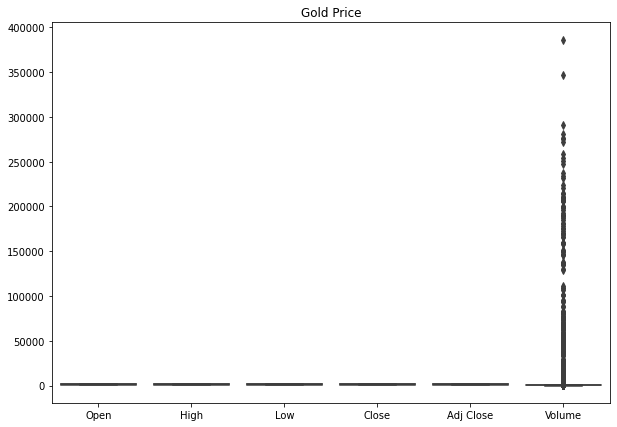

In [56]:
numerical_col = [col for col in df.columns if df[col].dtypes == 'float64']
plt.subplots(figsize=(10,7))
sns.boxplot(data=df[numerical_col]).set_title("Gold Price")
plt.show()

In [57]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
df=df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  after removing the cwd from sys.path.


(4550, 7)

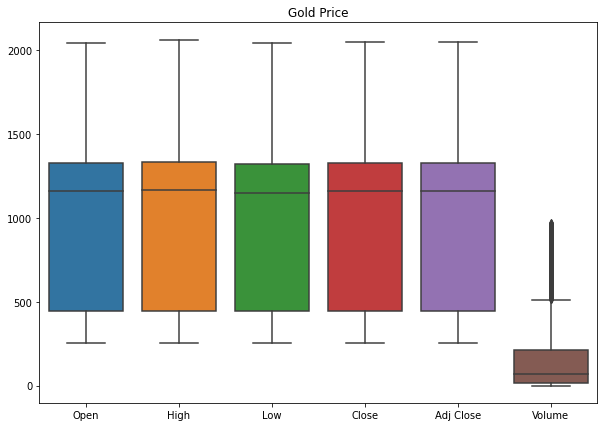

In [58]:
numerical_col = [col for col in df.columns if df[col].dtypes == 'float64']
plt.subplots(figsize=(10,7))
sns.boxplot(data=df[numerical_col]).set_title("Gold Price")
plt.show()

# **Univariate Analysis**

Fitur yang diprediksi pada kasus ini adalah terfokus pada 'Adj Close'

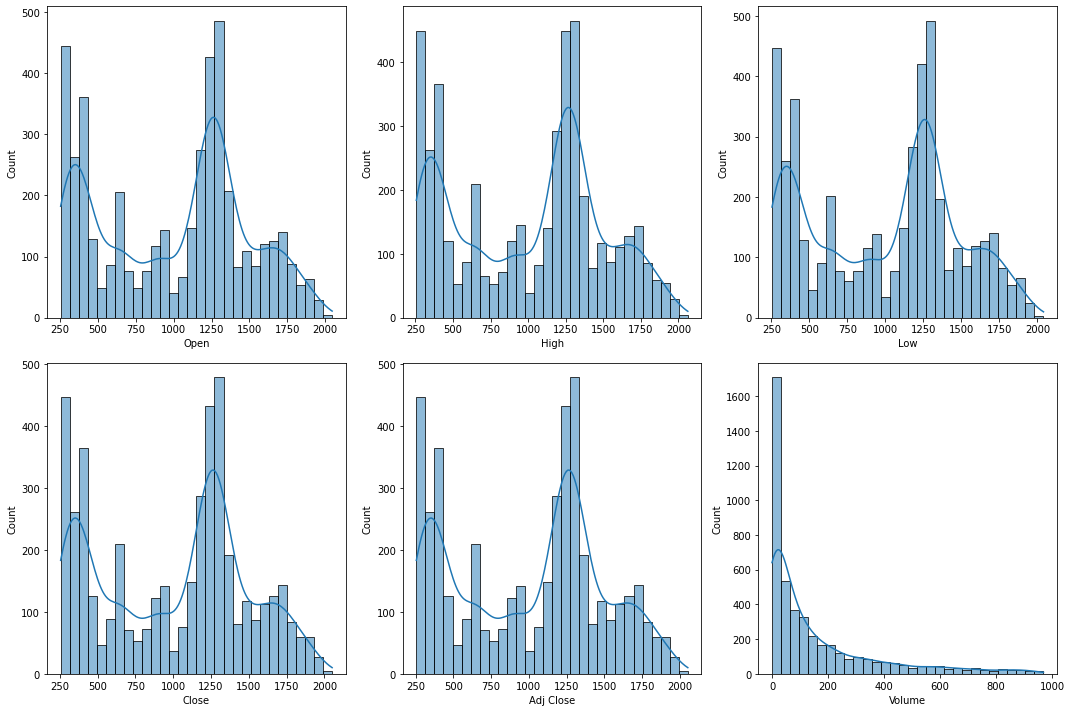

In [59]:
cols = 3
rows = 2
fig = plt.figure(figsize=(cols * 5, rows * 5))

for i, col in enumerate(numerical_col):
  ax = fig.add_subplot(rows, cols, i + 1)
  sns.histplot(x=df[col], bins=30, kde=True, ax=ax)
fig.tight_layout()
plt.show()

# **Multivariate Analysis**

Selanjutnya kita akan menganalisis korelasi fitur "Adj Close" terhadap fitur lain seperti "Open", "High", "Low", "Close" dan "Volume". Dapat disimpulkan bahwa "Adj Close" memiliki korelasi positif yang kuat terhadap "Open", "High", "Low" dan "Close", sedangkan untuk fitur "Volume" memiliki korelasi sedang terhadap fitur "Adj Close"



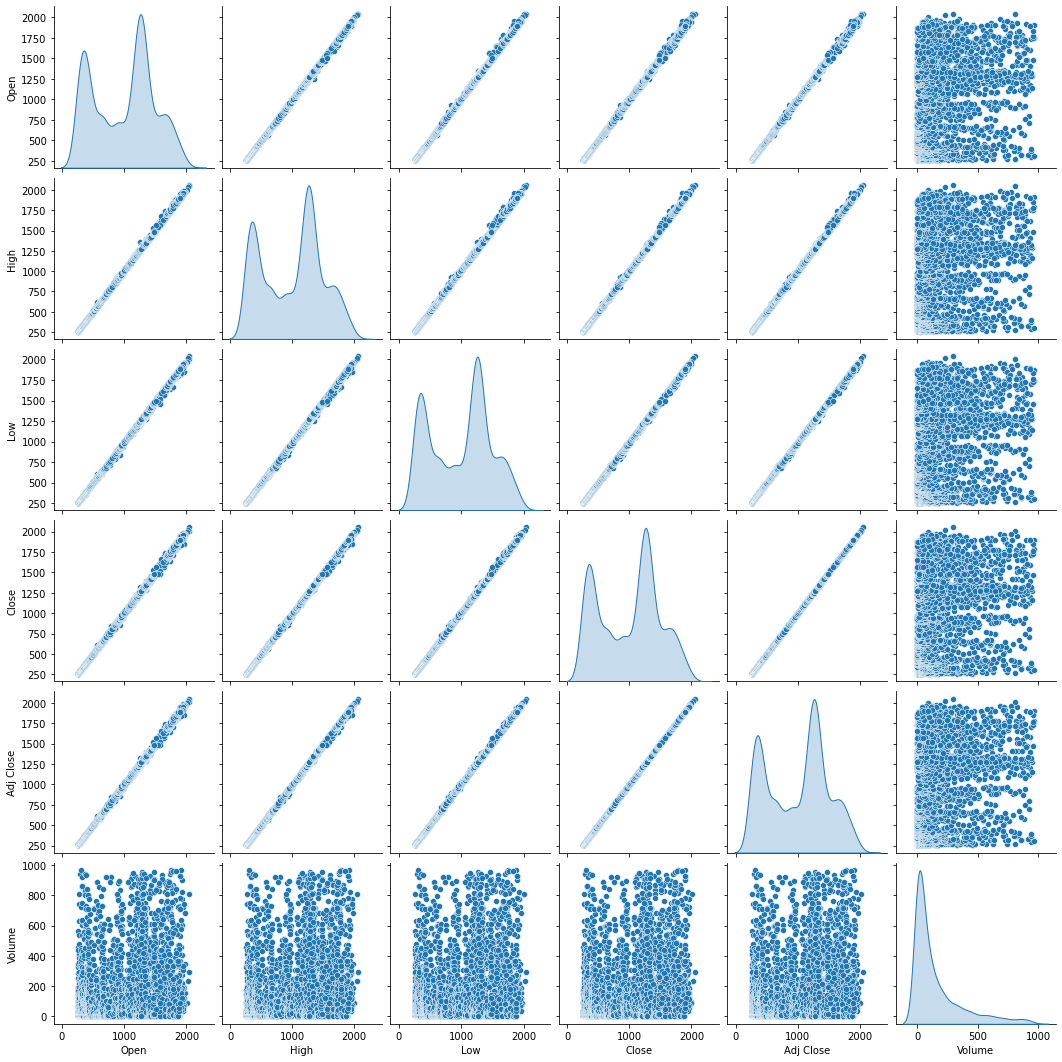

In [60]:
sns.pairplot(df[numerical_col], diag_kind='kde')
plt.show()

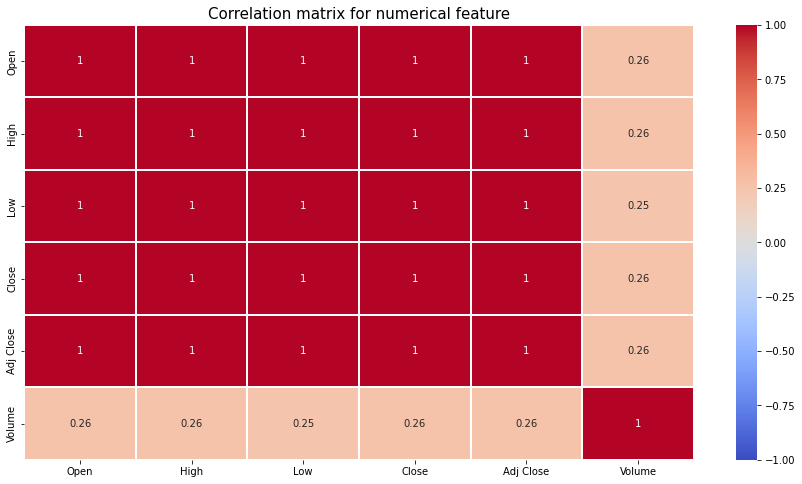

In [61]:
plt.figure(figsize=(15,8))
corr = df[numerical_col].corr().round(2)
sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm', linewidth=1)
plt.title('Correlation matrix for numerical feature', size=15)
plt.show()

In [62]:
df = df.drop(['Date','Volume', 'Close'], axis=1)
df.head()

,Open,High,Low,Adj Close
0,273.899994,273.899994,273.899994,273.899994
1,274.799988,278.299988,274.799988,278.299988
2,277.000000,277.000000,277.000000,277.000000
4,275.799988,275.799988,275.799988,275.799988
5,274.200012,274.200012,274.200012,274.200012


# **Splitting Dataset**

In [64]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [66]:
print(len(X_train), 'records')
print(len(y_train), 'records')
print(len(X_test), 'records')
print(len(y_test), 'records')

3640 records
3640 records
910 records
910 records


# **Data Normalization**

Untuk melakukan normalisasi data kita akan menggunakan library MinMaxScaler. Fungsi normalisasi pada data agar model lebih cepat dalam mempelajari data karena data telah diubah pada rentang tertentu seperti antara 0 dan 1

In [67]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
models = pd.DataFrame(columns=['train_mse', 'test_mse'], index=['SVR', 'KNN', 'GradientBoosting'])

# **Modeling**
**Hyperparameter Tuning**
Hyperparameter tuning adalah salah satu teknik yang dilakukan akan model dapat berjalan dengan performa terbaik. Biasanya dalam hyperparameter tuning, hyperparameter akan ditentukan secara acak oleh teknisi. Namun jika tidak ingin mencoba coba hyperparameter mana yang terbaik, kita dapat menggunakan GridSearch. GridSearch merupakan sebuah teknik yang memungkinkan kita untuk menguji beberapa hyperparameter sekaligus pada sebuah model

In [69]:
def grid_search(model, hyperparameters):
  results = GridSearchCV(
      model,
      hyperparameters,
      cv=5,
      verbose=1,
      n_jobs=6
  )

  return results

In [70]:
svr = SVR()
hyperparameters = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 10, 100, 1000],
    'gamma': [0.3, 0.03, 0.003, 0.0003]
}

svr_search = grid_search(svr, hyperparameters)
svr_search.fit(X_train, y_train)
print(svr_search.best_params_)
print(svr_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 1000, 'gamma': 0.3, 'kernel': 'rbf'}
0.9999017248097795


In [71]:
gradient_boost = GradientBoostingRegressor()
hyperparameters = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'n_estimators': [250, 500, 750, 1000],
    'criterion': ['friedman_mse', 'squared_error']
}

gradient_boost_search = grid_search(gradient_boost, hyperparameters)
gradient_boost_search.fit(X_train, y_train)
print(gradient_boost_search.best_params_)
print(gradient_boost_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'n_estimators': 1000}
0.9998279715611396


In [72]:
knn = KNeighborsRegressor()
hyperparameters = {
    'n_neighbors': range(1, 10)
}

knn_search = grid_search(knn, hyperparameters)
knn_search.fit(X_train, y_train)
print(knn_search.best_params_)
print(knn_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'n_neighbors': 5}
0.9998508552625586


# **Model Training**

In [73]:
svr = SVR(C=10, gamma=0.3, kernel='rbf')
svr.fit(X_train, y_train)

SVR(C=10, gamma=0.3)

In [74]:
gradient_boost = GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01, n_estimators=1000)
gradient_boost.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01,
                          n_estimators=1000)

In [75]:
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=9)

# **Model Evaluation**

In [76]:
model_dict = {
    'SVR': svr,
    'GradientBoosting': gradient_boost,
    'KNN': knn,
}

for name, model in model_dict.items():
  models.loc[name, 'train_mse'] = mean_squared_error(y_train, model.predict(X_train))
  models.loc[name, 'test_mse'] = mean_squared_error(y_test, model.predict(X_test))

models.head()

,train_mse,test_mse
SVR,508.571396,604.960402
KNN,26.853976,32.213449
GradientBoosting,16.553528,32.62577


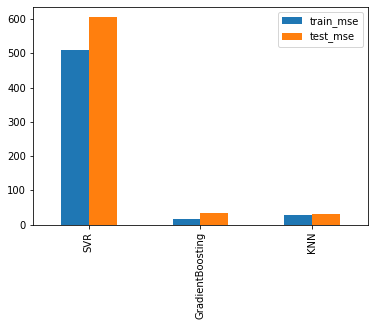

In [77]:
models.sort_values(by='test_mse', ascending=False).plot(kind='bar', zorder=3)